In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from autoplan.neighbors import TreeNNClassifier
from autoplan.token import OCamlTokenizer, TokenType, PyretTokenizer
from autoplan.trainer import ClassifierTrainer
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.dataset import TrainVal, RandomSplit, concat_datasets

import numpy as np
import dataclasses
import torch
from tqdm.auto import tqdm
from torch import nn
from torch.utils.data import Subset
from scripts.rainfall_ingest import ingest_dataset, load_full_t1
import pandas as pd
from pickle_cache import PickleCache
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

pcache = PickleCache()
device = torch.device('cuda:6')

In [5]:
datasets = {
    'T1': [load_full_t1(preprocess=False), load_full_t1(preprocess=True)],
    'T1Acc': [ingest_dataset('T1Acc', preprocess=False), ingest_dataset('T1Acc', preprocess=True)]
}

Skipped 16 programs
Skipped 16 programs
Skipped 2 programs
Skipped 2 programs


In [55]:
ks = [1, 3, 5, 10, 20]
#evals = {}
for (lang, lang_ds), tokenizer in zip(datasets.items(), [OCamlTokenizer(), PyretTokenizer()]):
    if lang == 'T1Acc':
        continue
    evals[lang] = []
    for ds in lang_ds:
        cls = TreeNNClassifier(ds, tokenizer)
        dist_matrix = cls.compute_distance_matrix(cls.programs)
        evals[lang].append({
            k: [evl.accuracy for evl in cls.crossval(dist_matrix, folds=30, k=k)]
            for k in ks
        })

In [53]:
[
    condition[sorted([(k, np.mean(acc)) for k, acc in condition.items()], key=lambda t: -t[1])[0][0]]
    for condition in evals['T1Acc']
]

[[0.6153846153846154,
  0.5384615384615384,
  0.5384615384615384,
  0.6153846153846154,
  0.38461538461538464,
  0.6153846153846154,
  0.6923076923076923,
  0.6923076923076923,
  0.46153846153846156,
  0.6923076923076923,
  0.6923076923076923,
  0.5384615384615384,
  0.46153846153846156,
  0.38461538461538464,
  0.5384615384615384,
  0.6923076923076923,
  0.5384615384615384,
  0.5384615384615384,
  0.8461538461538461,
  0.5384615384615384,
  0.3076923076923077,
  0.6153846153846154,
  0.6923076923076923,
  0.7692307692307693,
  0.6153846153846154,
  0.6153846153846154,
  0.6153846153846154,
  0.38461538461538464,
  0.6923076923076923,
  0.5384615384615384],
 [0.6923076923076923,
  0.6923076923076923,
  0.6923076923076923,
  0.7692307692307693,
  0.8461538461538461,
  0.6923076923076923,
  0.9230769230769231,
  0.7692307692307693,
  0.6923076923076923,
  0.7692307692307693,
  0.7692307692307693,
  0.6153846153846154,
  0.6923076923076923,
  0.6153846153846154,
  0.7692307692307693,
  0.

In [28]:
t1acc_evals = evals['T1Acc']

In [30]:
rnn_evals = {}
for (lang, lang_ds), tokenizer in zip(datasets.items(), [OCamlTokenizer(), PyretTokenizer()]):
    rnn_evals[lang] = []
    for ds in lang_ds:
        rnn_evals[lang].append(ClassifierTrainer.crossval(
            ds, k=30, device=device, split=RandomSplit(ds), val_frac=0.33, epochs=100,
            model_opts={'model': nn.LSTM, 'hidden_size': 512, 'embedding_size': 128}))

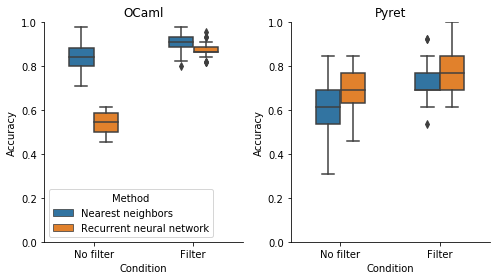

In [70]:
knn_acc = pd.DataFrame([
    {'Language': 'OCaml' if lang == 'T1' else 'Pyret', 'Method': 'Nearest neighbors',
    'Condition': name, 'Accuracy': acc}
    for lang in ['T1', 'T1Acc']
    for name, condition in zip(['No filter', 'Filter'], evals[lang])
    for acc in condition[sorted([(k, np.mean(acc)) for k, acc in condition.items()], key=lambda t: -t[1])[0][0]]
])

rnn_acc = pd.DataFrame([
    {'Language': 'OCaml' if lang == 'T1' else 'Pyret', 'Method': 'Recurrent neural network',
     'Condition': name, 'Accuracy': max([evl.accuracy for evl in val_evals])} 
    for lang in ['T1', 'T1Acc']
    for name, condition in zip(['No filter', 'Filter'], rnn_evals[lang])
    for val_evals in condition['val_eval']
])

all_acc = pd.concat([knn_acc, rnn_acc])

_, axes = plt.subplots(ncols=2, figsize=(7, 4))
for i, (ax, lang) in enumerate(zip(axes, ['OCaml', 'Pyret'])):
    sns.boxplot(x='Condition', y='Accuracy', hue='Method', data=all_acc[all_acc.Language == lang], ax=ax, width=0.5)
    sns.despine()
    ax.set_title(lang)
    ax.set_ylim(0, 1)
    if i == 1: ax.legend().remove()
        
plt.tight_layout()
plt.savefig('test-filter.pdf')